In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import * 

In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv("circuits_data400000.csv")

df = df.replace(
    ["none", "None", "NONE", "", "null", "NULL"],
    np.nan
)

C:\Users\aadik\AppData\Local\Temp\ipykernel_10680\2487107280.py:4: DtypeWarning: Columns (3,5,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("circuits_data400000.csv")


In [3]:
FEATURES = [
    # Circuit size & structure
    "num_qubits",
    # "circuit_qubits",
    "width",
    "depth",
    # "circuit_depth",
    "circuit_size",
    # "gate_counts",
    "pauli_gate_count",
    "two_qubit_gate_count",
    "two_qubit_gate_percentage",
    # "transpiled_depth",
    # "transpiled_size",
    # "transpiled_qubits",

    # Graph features
    "igdepth",
    "node_count",
    "edge_count",
    "average_degree",
    "max_degree",
    "average_shortest_path_length",
    "average_clustering_coefficient",
    "diameter",
    "radius",
    # "pagerank",
    # # "core_number",
    # # "connected_components",
    "central_point_of_dominance",
    "density_score",
    "std_dev_adjacency_matrix",
    "min_cut_upper",

    # Sparsity / locality
    # "sparsity",
    "locality_ratio",
    "idling_score",
    # "statevector_entropy",
    "statevector_saved_entropy",
    "statevector_saved_sparsity",
]


In [4]:
before = len(df)
df_dropped = df.dropna(subset=FEATURES)[FEATURES]
after = len(df_dropped)
df = df_dropped

print(f"Rows kept: {after/before:.2%}")
print(after)

Rows kept: 44.28%
177129


In [5]:
# Let us train a regression model to estimate sparsity and entropy.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor

TARGET_SPARSITY = "statevector_saved_sparsity"
TARGET_ENTROPY = "statevector_saved_entropy"
FEATURES_CLEAN = [
    f for f in FEATURES
    if f not in [TARGET_ENTROPY, TARGET_SPARSITY]
]
X = df[FEATURES_CLEAN]
y_sparsity = df[TARGET_SPARSITY]
y_entropy = df[TARGET_ENTROPY]

X_train, X_test, y_s_train, y_s_test, y_e_train, y_e_test = train_test_split(
    X, y_sparsity, y_entropy,
    test_size=0.2,
    random_state=42
)
print(len(X), len(X_train), len(X_test))

177129 141703 35426


In [11]:
from sklearn.ensemble import RandomForestRegressor

sparsity_model = RandomForestRegressor(
    n_estimators=100,      # ↓ from 300
    max_depth=15,          # LIMIT depth
    min_samples_leaf=5,    # prevent overfitting
    random_state=42,
    n_jobs=-1
)

entropy_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

sparsity_model.fit(X_train, y_s_train)
entropy_model.fit(X_train, y_e_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",15
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [7]:
from sklearn.linear_model import LinearRegression

sparsity_model = LinearRegression()
entropy_model = LinearRegression()

sparsity_model.fit(X_train, y_s_train)
entropy_model.fit(X_train, y_e_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [8]:
from sklearn.linear_model import Ridge

sparsity_model = Ridge(alpha=1.0)
entropy_model = Ridge(alpha=1.0)

sparsity_model.fit(X_train, y_s_train)
entropy_model.fit(X_train, y_e_train)


,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None
,"tol tol: float, default=1e-4The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for each solver:- 'svd': `tol` has no impact.- 'cholesky': `tol` has no impact.- 'sparse_cg': norm of residuals smaller than `tol`.- 'lsqr': `tol` is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.- 'sag' and 'saga': relative change of coef smaller than `tol`.- 'lbfgs': maximum of the absolute (projected) gradient=max|residuals| smaller than `tol`... versionchanged:: 1.2 Default value changed from 1e-3 to 1e-4 for consistency with other linear models.",0.0001
,"solver solver: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'Solver to use in the computational routines:- 'auto' chooses the solver automatically based on the type of data.- 'svd' uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than 'cholesky' at the cost of being slower.- 'cholesky' uses the standard :func:`scipy.linalg.solve` function to obtain a closed-form solution.- 'sparse_cg' uses the conjugate gradient solver as found in :func:`scipy.sparse.linalg.cg`. As an iterative algorithm, this solver is more appropriate than 'cholesky' for large-scale data (possibility to set `tol` and `max_iter`).- 'lsqr' uses the dedicated regularized least-squares routine :func:`scipy.sparse.linalg.lsqr`. It is the fastest and uses an iterative procedure.- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from :mod:`sklearn.preprocessing`.- 'lbfgs' uses L-BFGS-B algorithm implemented in :func:`scipy.optimize.minimize`. It can be used only when `positive` is True.All solvers except 'svd' support both dense and sparse data. However, only'lsqr', 'sag', 'sparse_cg', and 'lbfgs' support sparse input when`fit_intercept` is True... versionadded:: 0.17 Stochastic Average Gradient descent solver... versionadded:: 0.19 SAGA solver.",'auto'
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.Only 'lbfgs' solver is supported in this case.",False
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag' or 'saga' to shuffle the data.See :term:`Glossary ` for details... versionadded:: 0.17 `random_state` to support Stochastic Average Gradient.",None


In [16]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"{name}")
    print(f"  R²   : {r2_score(y_test, y_pred):.4f}")
    print(f"  RMSE : {rmse:.4f}")
    print()

evaluate(sparsity_model, X_test, y_s_test, "Sparsity Model")
evaluate(entropy_model, X_test, y_e_test, "Entropy Model")


Sparsity Model
  R²   : 0.7647
  RMSE : 0.1892

Entropy Model
  R²   : 0.8849
  RMSE : 1.9440



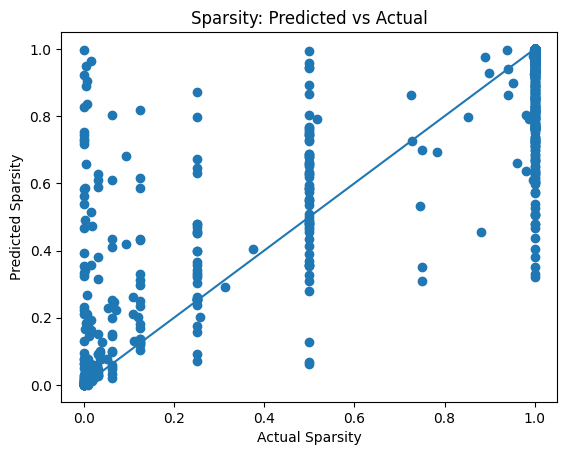

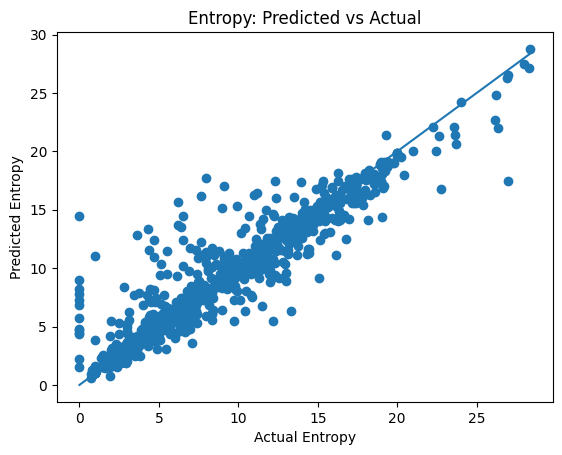

In [17]:
new_X = X_test.iloc[:1000]

sparsity_pred = sparsity_model.predict(new_X)
entropy_pred = entropy_model.predict(new_X)

actual_sparsity = y_s_test.iloc[:1000]
actual_entropy = y_e_test.iloc[:1000]

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(actual_sparsity, sparsity_pred)
plt.plot(
    [actual_sparsity.min(), actual_sparsity.max()],
    [actual_sparsity.min(), actual_sparsity.max()]
)
plt.xlabel("Actual Sparsity")
plt.ylabel("Predicted Sparsity")
plt.title("Sparsity: Predicted vs Actual")
plt.show()

plt.figure()
plt.scatter(actual_entropy, entropy_pred)
plt.plot(
    [actual_entropy.min(), actual_entropy.max()],
    [actual_entropy.min(), actual_entropy.max()]
)
plt.xlabel("Actual Entropy")
plt.ylabel("Predicted Entropy")
plt.title("Entropy: Predicted vs Actual")
plt.show()
